In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching
from imp import reload
reload(alpenglow.stitching)
reload(alpenglow.files)
from alpenglow.stitching import stitch, find_shift, apply_shift

In [2]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage
import dask.array as da
from dask import delayed
import mahotas as mh

In [3]:
s3 = boto3.resource('s3')

bucket = s3.Bucket('alpenglowoptics')

ll = list(bucket.objects.all())

In [6]:
phantom = []
for item in ll:
    if item.key.startswith("phantom_2_7_2017/000001"):
        phantom.append(item.key)

In [7]:
imread = delayed(skimage.io.imread, pure=True)  # Lazy version of imread
filenames = []
strip = 1
for x in range(1,len(phantom)):
    fname = "%06d_%05d.tif" % (strip, x)
    filenames.append('../data/phantom_2_7_2017/%06d/' %strip + fname)

In [8]:
len(filenames)

1800

In [7]:
lazy_values = [imread(filename) for filename in filenames]

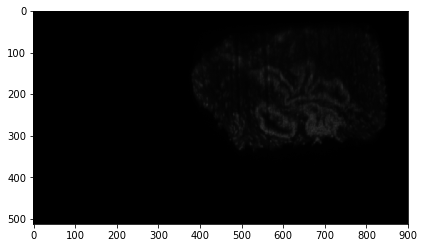

In [8]:
sample = skimage.io.imread(filenames[100])
skimage.io.imshow(sample)

In [9]:
arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]

In [10]:
stack = da.stack(arrays, axis=0)                # Stack all small Dask arrays into one

In [16]:
stack.shape[1]

512

In [21]:
for z in range(1,stack.shape[1]+1):
    filename = '../data/phantom_2_7_2017/%06d/%06d_%06d.tif' % (strip, strip, z) 
    tiff.imsave(filename, stack[:,z,:].compute())
zstack = ImageCollection('zstack_%06d_*.tif' % strip )

SyntaxError: can't assign to operator (<ipython-input-21-7fdc88cc1c5b>, line 2)

### Creating ImageCollection for strips 0, 1, and 2

In [39]:
imread = delayed(skimage.io.imread, pure=True)  # Lazy version of imread
filenames = []
strip = 0
for x in range(1,len(phantom)):
    fname = "%06d_%05d.tif" % (strip, x)
    filenames.append('../data/phantom_2_7_2017/%06d/' %strip + fname)

In [40]:
lazy_values = [imread(filename) for filename in filenames]
sample = skimage.io.imread(filenames[100])

In [41]:
arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]

In [42]:
stack = da.stack(arrays, axis=0)  

In [ ]:
for z in range(1,stack.shape[1]+1):
    filename = '../data/phantom_2_7_2017/000000/000000_%06d.tif' % z 
    tiff.imsave(filename, stack[:,z,:].compute())
zstack_0 = ImageCollection('../data/phantom_2_7_2017/000000/000000_*.tif' )

In [ ]:
zstack_0

In [9]:
zstack_1 = ImageCollection('../data/phantom_2_7_2017/000001/000001_*.tif' )

In [10]:
len(zstack_1)

512

### Trying a surface extraction

In [11]:
zstack_1_array = skimage.io.concatenate_images(zstack_1)

In [13]:
stack,h,w = zstack_1_array.shape

In [14]:
stack,h,w 

(512, 512, 900)

In [16]:
focus = np.array([mh.sobel(t, just_filter=True) for t in zstack_1_array])

In [18]:
best = np.argmax(focus, 0)

In [20]:
zstack_1_array = zstack_1_array.reshape((stack,-1)) # image is now (stack, nr_pixels)
zstack_1_array = zstack_1_array.transpose() # image is now (nr_pixels, stack)
r = zstack_1_array[np.arange(len(zstack_1_array)), best.ravel()] # Select the right pixel at each location
r = r.reshape((h,w)) # reshape to get final result

IndexError: too many indices for array

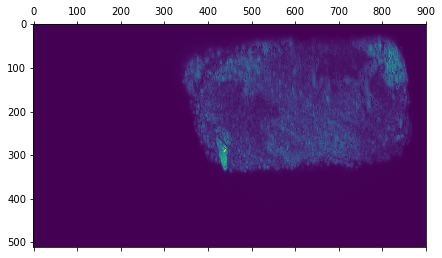

In [23]:
plt.matshow(r)
plt.matshow(zstack_1_array[:,20,:])

### Using 76AO subsample to try surface extraction

In [4]:
# pulling images for strips 7-12 from S3
for x in range(1,129):
    for strip in [7,8,9,10,11,12]:
        fname = "im_%06d_%06d.tif" % (strip, x)
        af.download_s3('76AO/Strips/' + fname, '../data/' + fname)

In [5]:
# creating image collections
images_7 = imread_collection("../data/im_000007_0*")
images_8 = imread_collection("../data/im_000008_0*")
images_9 = imread_collection("../data/im_000009_0*")
images_10 = imread_collection("../data/im_000010_0*")
images_11 = imread_collection("../data/im_000011_0*")
images_12 = imread_collection("../data/im_000012_0*")

In [35]:
#reading image collection for strip 7 into an array
zstack7_array = skimage.io.concatenate_images(images_7)

MemoryError: 

In [ ]:
stack,h,w = zstack7_array.shape
stack,h,w

In [ ]:
zstack7_array = zstack7_array[:33, :, :] #128 was too big

In [ ]:
stack,h,w = zstack7_array.shape
stack,h,w

In [ ]:
focus = np.array([mh.sobel(t, just_filter=True) for t in zstack7_array])

In [ ]:
best = np.argmax(focus, 0)

In [ ]:
zstack7_array = zstack7_array.reshape((stack,-1)) # image is now (stack, nr_pixels)
zstack7_array = zstack7_array.transpose() # image is now (nr_pixels, stack)
r = zstack7_array[np.arange(len(zstack7_array)), best.ravel()] # Select the right pixel at each location
r = r.reshape((h,w)) # reshape to get final result

In [ ]:
image7_32 = tiff.imread('../data/im_000007_000032.tif')
image7_max = np.max(images_7, axis=0)
plt.matshow(r[:,10000:15000])
plt.matshow(image7_32[:,10000:15000])
plt.matshow(image7_max[:,10000:15000])

Goldilocks: The 32nd image was best. Surface extraction had too little info, max intensity had too much info.